In [12]:
import easyocr
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import sys
print(sys.executable)
!python --version
!pip list | grep easyocr
!pip list | grep torch


/Users/markshteyn/projects/filefly/notebooks/env/bin/python
Python 3.12.8
easyocr                1.7.2
torch                  2.5.1.post7
torchvision            0.20.1


In [20]:
import hashlib 

# Load the baseball.jpg as bytes
with open("data/baseball.jpg", "rb") as f:
    # Initialize the EasyOCR Reader
    reader = easyocr.Reader(['en'], gpu=False)
    image_bytes = f.read()
    np_array = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
    print("Image shape:", image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    results = reader.readtext(image)
    print("MD5 in Notebook:", hashlib.md5(image_bytes).hexdigest())
    print(results)

Using CPU. Note: This module is much faster with a GPU.


Image shape: (864, 1536, 3)
MD5 in Notebook: ad68a320f2d669de1cfd106343663c7e
[([[np.int32(703), np.int32(327)], [np.int32(743), np.int32(327)], [np.int32(743), np.int32(375)], [np.int32(703), np.int32(375)]], '8 .', np.float64(0.0873477489908724)), ([[np.float64(386.13593527016354), np.float64(61.62718705403271)], [np.float64(667.5268771541449), np.float64(11.47020265343221)], [np.float64(677.8640647298364), np.float64(66.37281294596728)], [np.float64(396.47312284585513), np.float64(116.52979734656779)]], '(oea', np.float64(0.22668518126010895)), ([[np.float64(514.2264990188738), np.float64(266.8397485283108)], [np.float64(650.4574259251086), np.float64(245.73475075937105)], [np.float64(655.7735009811262), np.float64(290.1602514716892)], [np.float64(519.5425740748914), np.float64(312.2652492406289)]], 'OFFICIAL', np.float64(0.9711339234081768)), ([[np.float64(626.6923076923077), np.float64(280.46153846153845)], [np.float64(789.5129545948804), np.float64(263.63201950287015)], [np.float

ad68a320f2d669de1cfd106343663c7e
ad68a320f2d669de1cfd106343663c7e

In [15]:
# Calculate centroids for each bounding box
def calculate_centroid(bbox):
    x_coords = [point[0] for point in bbox]
    y_coords = [point[1] for point in bbox]
    return np.mean(x_coords), np.mean(y_coords)

def test_easyocr(image_path):
    """
    Test EasyOCR on an image and visualize the results.

    Parameters:
    - image_path (str): Path to the image file.
    """
    # Initialize the EasyOCR Reader
    reader = easyocr.Reader(['en'])

    # Load the image as bytes
    image = cv2.imread(image_path)
    image_bytes = cv2.imencode('.jpg', image)[1].tobytes()
    
    if image is None:
        print("Error: Could not load the image. Check the file path.")
        return
    
    # Convert the imagebytes back 
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform OCR
    results = reader.readtext(image)
    
    # Filter out unconfident results
    results = [(bbox, text, conf) for (bbox, text, conf) in results if conf > 0.5]
    
    # Add centroids to the results for sorting
    results_with_centroids = []
    for result in results:
        bbox, text, confidence = result
        centroid = calculate_centroid(bbox)
        results_with_centroids.append((centroid, text, confidence, bbox))
        
    # Sort by top-to-bottom and left-to-right
    sorted_results = sorted(
        results_with_centroids,
        key=lambda x: (x[0][1], x[0][0])  # First sort by y (top-to-bottom), then by x (left-to-right)
    )

    # Visualize the results
    for (centroid, text, conf, bbox) in sorted_results:
        # Extract the bounding box coordinates
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))

        # Draw the bounding box
        cv2.rectangle(image_rgb, top_left, bottom_right, (0, 255, 0), 2)

        # Put the detected text
        cv2.putText(image_rgb, f"{text} ({conf:.2f})", (top_left[0], top_left[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Display the image with detected text
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Detected Text with EasyOCR')
    plt.show()
    
    return sorted_results

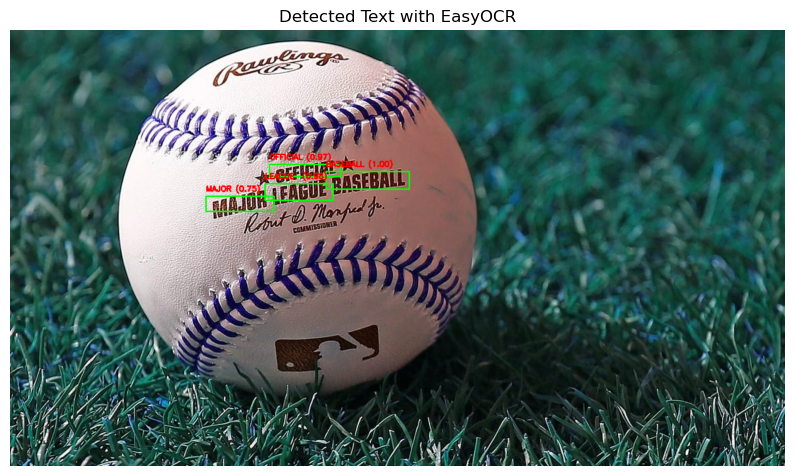

In [16]:
image_path = "data/image_test.jpg" 
results = test_easyocr(image_path)

In [17]:
results

[((np.float64(585.0), np.float64(278.75)),
  'OFFICIAL',
  np.float64(0.9749771629033274),
  [[np.float64(514.2264990188738), np.float64(266.8397485283108)],
   [np.float64(650.4574259251086), np.float64(245.73475075937105)],
   [np.float64(655.7735009811262), np.float64(290.1602514716892)],
   [np.float64(519.5425740748914), np.float64(312.2652492406289)]]),
 ((np.float64(709.25), np.float64(298.0)),
  'BASEBALL',
  np.float64(0.9987884798081121),
  [[np.float64(626.6923076923077), np.float64(280.46153846153845)],
   [np.float64(789.5129545948804), np.float64(263.63201950287015)],
   [np.float64(791.3076923076923), np.float64(315.53846153846155)],
   [np.float64(629.4870454051196), np.float64(332.36798049712985)]]),
 ((np.float64(573.25), np.float64(321.0)),
  'LEACUE ',
  np.float64(0.9765966053188295),
  [[np.float64(505.5171823341929), np.float64(304.53780113522436)],
   [np.float64(635.1409389364023), np.float64(283.9063376311915)],
   [np.float64(640.4828176658071), np.float64(33

In [18]:
extracted_text = [result[1] for result in results]
extracted_text  

['OFFICIAL', 'BASEBALL', 'LEACUE ', 'MAJOR']